# Comparison of the content of the dataset documentation approaches

Before using add the "metadata-elements-comparison.xlsx" file in the "inputs" folder (see the README for details)

## Import required packages and set plot settings

In [1]:
import itertools
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer

In [2]:
sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

colors = ["#073b4c", "#ffd166", "#06d6a0"]
patterns = ["/", "\\", "-", "+", "x", "o", "O", ".", "*", "|"]

## Load data

In [4]:
dfs = pd.read_excel(
    "inputs/dataset/primary/metadata-elements-comparison.xlsx", sheet_name=None
)
df_list = dfs["List"]
del dfs["List"]
display(dfs["Datasheet"])
display(df_list)

,Question or field,Metadata element
0,For what purpose was the dataset created? Was ...,Description of the purpose for creating the da...
1,"Who created the dataset (e.g., which team, res...",Information about the creators of the dataset
2,Who funded the creation of the dataset? If the...,Details about the funding of the dataset
3,Any other comments?,NaN
4,What do the instances that comprise the datase...,Description of the instances included in the d...
...,...,...
61,"Will the dataset be updated (e.g., to correct ...",Description of the dataset update plan
62,"If the dataset relates to people, are there ap...",Description of the dataset retention policy
63,Will older versions of the dataset continue to...,Description of the management plan for older v...
64,If others want to extend/augment/build on/cont...,Description of the methods to contribute to th...


,Metadata element,Critical for clinical research datasets,Anna,Lingling,Kyongmi,Fritz
0,Description of the dataset,Yes,NaN,NaN,NaN,NaN
1,Information about dataset audit/review,No,NaN,NaN,NaN,NaN
2,Information about the dataset versioning approach,No,NaN,NaN,NaN,NaN
3,Version of the dataset associated with this da...,Yes,NaN,NaN,NaN,NaN
4,Information about the dataset documentation fo...,No,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
134,Link to design document,No,NaN,NaN,NaN,NaN
135,Description of the relevance of the data,No,NaN,NaN,NaN,NaN
136,Description and results of the requirement tes...,No,NaN,NaN,NaN,NaN
137,Description and results of the adversarial tes...,No,NaN,NaN,NaN,NaN


## Check if any metadata elements are too similar and should be regrouped into one

In [5]:
# Get a list of all metadata elements
metadata_elements_list = []
for sheet, df in dfs.items():
    metadata_elements_list += list(df["Metadata element"])
metadata_elements_list = list(set(metadata_elements_list))
metadata_elements_list = [
    x for x in metadata_elements_list if str(x) != "nan"
]  # remove nan value
critical_df_list = df_list[df_list["Critical for clinical research datasets"] == "Yes"]
critical_metadata_elements_list = list(critical_df_list["Metadata element"])
df = pd.DataFrame(metadata_elements_list, columns=["Metadata element"])
# df.to_excel("outputs/metadata_elements_list.xlsx", index=False)
print("There are ", len(metadata_elements_list), " metadata elements")
print("There are ", len(critical_metadata_elements_list), " critical metadata elements")
display(df)

There are  139  metadata elements
There are  101  critical metadata elements


,Metadata element
0,Description of related datasets
1,Information about the dataset versioning approach
2,Known issues with data collection
3,Description of the dataset
4,Assumption in data fields not made explicit in...
...,...
134,Description of the process for creating this d...
135,Description of the restrictions on the usage o...
136,Description of the data annotation process
137,Version of the dataset associated with this da...


In [6]:
# Encode metadata elements
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(metadata_elements_list)

# Get and save cosine similarity scores
similar_rows = []
unique_index_pairs = list(
    itertools.combinations(list(range(len(metadata_elements_list))), 2)
)
for index_pair in unique_index_pairs:
    i = index_pair[0]
    j = index_pair[1]
    element1 = metadata_elements_list[i]
    element2 = metadata_elements_list[j]
    cosine_similarity = np.dot(embeddings[i], embeddings[j]) / (
        np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j])
    )
    similar_rows.append([element1, element2, cosine_similarity])
df_similar = pd.DataFrame(
    similar_rows, columns=["Element 1", "Element 2", "cosine similarity score"]
)
df_similar = df_similar.sort_values(by="cosine similarity score", ascending=False)
display(df_similar)
df_similar.to_excel("outputs/metadata_elements_similarity.xlsx")

,Element 1,Element 2,cosine similarity score
9238,Information about the dataset documentation fo...,Version of the dataset associated with this da...,0.954538
3839,Description of the intended use of the dataset,Description of the undesirable uses of the dat...,0.908756
3829,Description of the intended use of the dataset,Description of the purpose for creating the da...,0.896263
6583,Information the people consulted to create thi...,Description of the process for creating this d...,0.880714
1178,Information about the authors of this dataset ...,Information about the dataset documentation fo...,0.877440
...,...,...,...
5878,Description of other transformations,Recommendations when sampling the dataset,-0.099885
576,Assumption in data fields not made explicit in...,Link to design document,-0.106389
4070,Description of the consent revocation mechanism,Other dataset metrics besides size,-0.110900
5000,Description of the strategies to avoid undesir...,Last update date,-0.114775


Note: We ran this on the first version of our metadata element assignment where we had 146 unique metadata elements. We manually reviewed each pair of elements in descending order of cosine similarity value. We noticed that below a similarity score of 0.75, the elements were not similar and therefore we did not manually check below that. We identified 6 pairs of metadata elements that could be regrouped into one and ended up with a total of 140 unique metadata elements after that.

## View metadata elements and related questions/fields side-by-side for further review

In [7]:
documentation_list = list(dfs.keys())
retrouped_list = []
for metadata_element in metadata_elements_list:
    dict_questions = {}
    for sheet, df in dfs.items():
        df = df.loc[df["Metadata element"] == metadata_element]
        dict_questions[sheet] = list(df["Question or field"])
    count = 0
    not_all_nan = True
    while not_all_nan:
        row = []
        if count == 0:
            row.append(metadata_element)
        else:
            row.append(math.nan)
        for sheet in documentation_list:
            sheet_list = dict_questions[sheet]
            if len(sheet_list) > count:
                row.append(sheet_list[count])
            else:
                row.append(math.nan)
        if all(i != i for i in row):
            not_all_nan = False
        else:
            retrouped_list.append(row)
        count += 1
df_regrouped = pd.DataFrame(
    retrouped_list, columns=["Metadata element"] + documentation_list
)
display(df_regrouped)
df_regrouped.to_excel(
    "outputs/metadata_elements_regrouped_all_documentation_approaches.xlsx"
)

,Metadata element,Datasheet,Healthsheet,Data Card,Data Nutrition Label,Accountability Documentation
0,Description of related datasets,NaN,NaN,NaN,NaN,Which existing datasets are related to this on...
1,NaN,NaN,NaN,NaN,NaN,Dataset discovery process: how did you search ...
2,NaN,NaN,NaN,NaN,NaN,Documentation and DOI of Related Datasets
3,NaN,NaN,NaN,NaN,NaN,Motivation for the creation of Related Datasets
4,NaN,NaN,NaN,NaN,NaN,Intended Use of Related Datasets
...,...,...,...,...,...,...
301,NaN,NaN,NaN,Provide annotator distributions for each annot...,NaN,NaN
302,NaN,NaN,NaN,Provide annotator distributions for each annot...,NaN,NaN
303,NaN,NaN,NaN,Provide annotator distributions for each annot...,NaN,NaN
304,Version of the dataset associated with this da...,NaN,Is this datasheet created for the original ver...,Provide details about this version of the data...,Indicate which version of the dataset is being...,NaN


## Analysis

### Comparison matrix

In [8]:
df_comparison = pd.DataFrame(index=list(dfs.keys()), columns=list(dfs.keys()))
for documentation1 in df_comparison.index:
    df1 = dfs[documentation1]
    for documentation2 in df_comparison.columns:
        df2 = dfs[documentation2]
        df_comparison.loc[documentation1, documentation2] = (
            len(
                [
                    i
                    for i in list(df1["Metadata element"])
                    if i in list(df2["Metadata element"])
                ]
            )
            / len(list(df1["Metadata element"]))
            * 100
        )
df_comparison.to_excel("outputs/metadata_elements_comparison_matrix.xlsx")
display(df_comparison)

,Datasheet,Healthsheet,Data Card,Data Nutrition Label,Accountability Documentation
Datasheet,100.0,98.484848,37.878788,62.121212,40.909091
Healthsheet,77.173913,100.0,33.695652,51.086957,36.956522
Data Card,32.768362,35.028249,100.0,27.683616,28.813559
Data Nutrition Label,60.56338,67.605634,36.619718,100.0,43.661972
Accountability Documentation,32.911392,40.506329,31.64557,29.113924,100.0


### Occurence of metadata elements accross dataset documentation

In [9]:
elements_count_list = []
for metadata_element in metadata_elements_list:
    row = [metadata_element]
    for sheet, df in dfs.items():
        if metadata_element in list(df["Metadata element"]):
            row.append("Yes")
        else:
            row.append("No")
    row.append(len([i for i in row if i == "Yes"]))
    if metadata_element in critical_metadata_elements_list:
        row.append("Yes")
    else:
        row.append("No")
    elements_count_list.append(row)
df_element_count = pd.DataFrame(
    elements_count_list,
    columns=["Metadata element"] + list(dfs.keys()) + ["Count", "Critical"],
)
df_element_count = df_element_count.sort_values(by=["Count"], ascending=False)
df_element_count.to_excel("outputs/metadata_elements_count.xlsx")
display(df_element_count)

,Metadata element,Datasheet,Healthsheet,Data Card,Data Nutrition Label,Accountability Documentation,Count,Critical
31,Description of the intended use of the dataset,Yes,Yes,Yes,Yes,Yes,5,Yes
20,Description of the data collection process,Yes,Yes,Yes,Yes,Yes,5,Yes
25,Dataset publication date,Yes,Yes,Yes,Yes,Yes,5,Yes
29,Description of the dataset update plan,Yes,Yes,Yes,Yes,Yes,5,Yes
101,Information about the owners of the dataset,Yes,Yes,Yes,Yes,Yes,5,Yes
...,...,...,...,...,...,...,...,...
125,Description of benefits of the dataset compare...,No,No,Yes,No,No,1,No
127,Description of the study inclusion criteria,No,Yes,No,No,No,1,Yes
134,Description of the process for creating this d...,No,No,No,No,Yes,1,Yes
131,Description of the data quality measurements,No,No,No,No,Yes,1,Yes


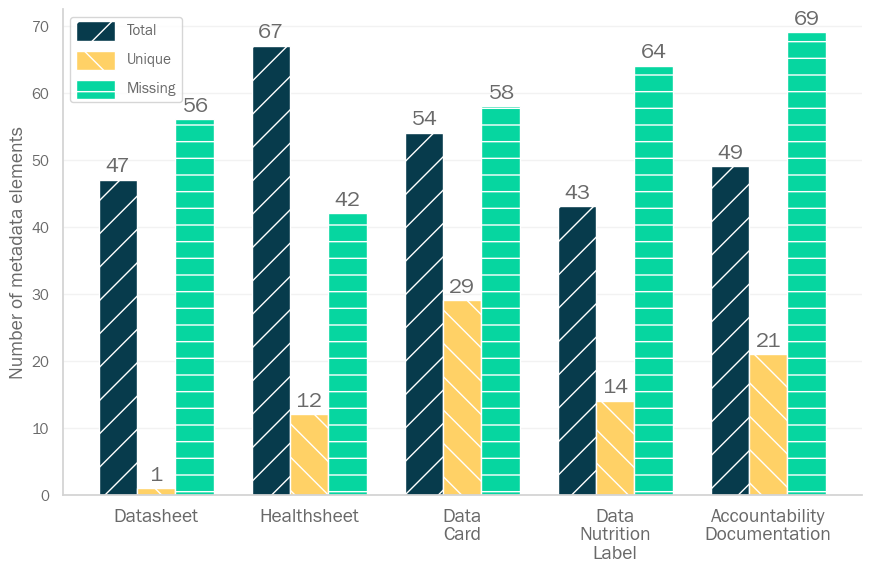

In [10]:
## Number of metadata elements and unique metadata elements per dataset documentation approach
count_metadata_elements = []
count_unique_metadata_elements = []
count_missing_critical_metadata_elements = []
labels = []
for doc in list(dfs.keys()):
    count_metadata_elements.append(df_element_count[doc].value_counts().get("Yes", 0))
    count_unique_metadata_elements.append(
        len(
            df_element_count[
                (df_element_count[doc] == "Yes") & (df_element_count["Count"] == 1)
            ]
        )
    )
    count_missing_critical_metadata_elements.append(
        len(critical_metadata_elements_list)
        - len(
            df_element_count[
                (df_element_count[doc] == "Yes")
                & (df_element_count["Critical"] == "Yes")
            ]
        )
    )
    if len(doc.split()) > 1:
        doc = "\n".join(doc.split())
    labels.append(doc)

# plot
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

width = 0.25
y_list = [
    count_metadata_elements,
    count_unique_metadata_elements,
    count_missing_critical_metadata_elements,
]
labels_list = ["Total", "Unique", "Missing"]
x = np.arange(len(labels))
count = 0
for y in y_list:
    bars = ax.bar(
        x + width * count,
        y,
        width,
        color=colors[count],
        hatch=patterns[count],
        label=labels_list[count],
    )
    ax.bar_label(bars, padding=3)
    count += 1

ax.set_xticks(x + width, labels, fontsize=14)
ax.set_ylabel("Number of metadata elements", fontsize=14)
ax.set_axisbelow(True)
leg = ax.legend(loc="upper left", labelspacing=1, handlelength=2.5, facecolor="white")
for patch in leg.get_patches():
    patch.set_height(14)
    patch.set_y(-5)
ax.grid(axis="y", color="0.95")
plt.grid(color="0.95", axis="y")

fig.tight_layout()
fig.savefig("outputs/metadata_elements_view.png", dpi=200)

In [11]:
# Most common metadata descriptions
display(df_element_count[df_element_count["Count"] == 5])

,Metadata element,Datasheet,Healthsheet,Data Card,Data Nutrition Label,Accountability Documentation,Count,Critical
31,Description of the intended use of the dataset,Yes,Yes,Yes,Yes,Yes,5,Yes
20,Description of the data collection process,Yes,Yes,Yes,Yes,Yes,5,Yes
25,Dataset publication date,Yes,Yes,Yes,Yes,Yes,5,Yes
29,Description of the dataset update plan,Yes,Yes,Yes,Yes,Yes,5,Yes
101,Information about the owners of the dataset,Yes,Yes,Yes,Yes,Yes,5,Yes
90,Description of the dataset sharing method,Yes,Yes,Yes,Yes,Yes,5,Yes
61,Details about the funding of the dataset,Yes,Yes,Yes,Yes,Yes,5,Yes


In [12]:
# Least common
for dataset_documentation in dfs.keys():
    print("----- Unique metadata description in " + dataset_documentation + " -----")
    display(
        df_element_count[
            (df_element_count["Count"] == 1)
            & (df_element_count[dataset_documentation] == "Yes")
        ]
    )

----- Unique metadata description in Datasheet -----


,Metadata element,Datasheet,Healthsheet,Data Card,Data Nutrition Label,Accountability Documentation,Count,Critical
6,Description of the possibilities to identify i...,Yes,No,No,No,No,1,Yes


----- Unique metadata description in Healthsheet -----


,Metadata element,Datasheet,Healthsheet,Data Card,Data Nutrition Label,Accountability Documentation,Count,Critical
1,Information about the dataset versioning approach,No,Yes,No,No,No,1,No
9,Description of the accessibility measurements,No,Yes,No,No,No,1,No
7,Description of the confounding factors that mi...,No,Yes,No,No,No,1,Yes
16,Guidelines for creating new labels,No,Yes,No,No,No,1,Yes
38,Number of subjects represented in the dataset,No,Yes,No,No,No,1,Yes
97,Description of the strategies to avoid reident...,No,Yes,No,No,No,1,Yes
79,Description of the factors in the data that mi...,No,Yes,No,No,No,1,Yes
119,Description of the regulation preventing demog...,No,Yes,No,No,No,1,No
110,Description of the choice(s) of language for c...,No,Yes,No,No,No,1,Yes
111,Information about the dataset documentation fo...,No,Yes,No,No,No,1,No


----- Unique metadata description in Data Card -----


,Metadata element,Datasheet,Healthsheet,Data Card,Data Nutrition Label,Accountability Documentation,Count,Critical
17,Details of the data points,No,No,Yes,No,No,1,No
74,Description of the aggregated data,No,No,Yes,No,No,1,Yes
73,Description of the dataset deletion process,No,No,Yes,No,No,1,Yes
70,Recommendations when this data is used with ot...,No,No,Yes,No,No,1,Yes
68,Definition of the acronyms and concepts used i...,No,No,Yes,No,No,1,Yes
69,Description of the human data attributes,No,No,Yes,No,No,1,No
67,Description of the prerequisites to access thi...,No,No,Yes,No,No,1,Yes
63,Description and handling of mismatched values,No,No,Yes,No,No,1,Yes
44,Information about the dataset publishers,No,No,Yes,No,No,1,Yes
46,Dataset maintenance status,No,No,Yes,No,No,1,Yes


----- Unique metadata description in Data Nutrition Label -----


,Metadata element,Datasheet,Healthsheet,Data Card,Data Nutrition Label,Accountability Documentation,Count,Critical
4,Assumption in data fields not made explicit in...,No,No,No,Yes,No,1,No
2,Known issues with data collection,No,No,No,Yes,No,1,Yes
10,Description of the involvement of the particip...,No,No,No,Yes,No,1,Yes
42,Description of the strategies to avoid undesir...,No,No,No,Yes,No,1,Yes
23,Information about the metadata repository and ...,No,No,No,Yes,No,1,No
60,Information the people consulted to create thi...,No,No,No,Yes,No,1,Yes
30,Keywords,No,No,No,Yes,No,1,No
103,Description of representation issues in the data,No,No,No,Yes,No,1,Yes
94,Description of the proxy characteristics in th...,No,No,No,Yes,No,1,No
85,Description of issues related to this dataset,No,No,No,Yes,No,1,Yes


----- Unique metadata description in Accountability Documentation -----


,Metadata element,Datasheet,Healthsheet,Data Card,Data Nutrition Label,Accountability Documentation,Count,Critical
0,Description of related datasets,No,No,No,No,Yes,1,No
19,Description of what is being tested in the dat...,No,No,No,No,Yes,1,Yes
71,Description of the dataset processing process,No,No,No,No,Yes,1,Yes
65,Information about the data collection cost,No,No,No,No,Yes,1,Yes
55,Description of the data distribution in the da...,No,No,No,No,Yes,1,No
43,Known caveats about the dataset,No,No,No,No,Yes,1,No
47,Description of the data rating process,No,No,No,No,Yes,1,No
35,Link to design document,No,No,No,No,Yes,1,No
37,Expectations for people using the dataset,No,No,No,No,Yes,1,No
36,Description of the ethical impact of the data ...,No,No,No,No,Yes,1,Yes
